<a href="https://colab.research.google.com/github/intelligenxe/gym-anytrading-RL/blob/main/RL_Trading_Agent_4_0(inx).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Installation of Libraries

In [1]:
!pip install git+https://github.com/DLR-RM/stable-baselines3@feat/gymnasium-support
!pip install git+https://github.com/Stable-Baselines-Team/stable-baselines3-contrib@feat/gymnasium-support

  Cloning https://github.com/DLR-RM/stable-baselines3 (to revision feat/gymnasium-support) to /tmp/pip-req-build-4ktae344
  Running command git clone --filter=blob:none --quiet https://github.com/DLR-RM/stable-baselines3 /tmp/pip-req-build-4ktae344
  Running command git checkout -q feat/gymnasium-support
  error: pathspec 'feat/gymnasium-support' did not match any file(s) known to git
  error: subprocess-exited-with-error
  
  × git checkout -q feat/gymnasium-support did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: subprocess-exited-with-error

× git checkout -q feat/gymnasium-support did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.
  Cloning https://github.com/Stable-Baselines-Team/stable-baselines3-contrib (to revision feat/gymnasium-support) to /tmp/pip-req-build-

In [2]:
!pip install gym-anytrading

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.2/172.2 kB 4.6 MB/s eta 0:00:00


In [3]:
!pip install shimmy>=0.2.1

In [4]:
!pip install finta

In [5]:
!pip install quantstats

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 1.9 MB/s eta 0:00:00


## Importing RL libraries

In [6]:
# Gym stuff
import gym
import gym_anytrading
from gym_anytrading.envs import StocksEnv

# Stable baselines - rl stuff
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3 import A2C
from stable_baselines3.common.sb2_compat.rmsprop_tf_like import RMSpropTFLike


# Processing libraries
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Stock Market Data

In [7]:
import yfinance as yf
import pandas as pd

In [8]:
df = yf.download('TQQQ', start='2019-01-01')       # insert stock ticker and start of the date range

[*********************100%%**********************]  1 of 1 completed


In [9]:
df = df.drop('Adj Close', axis=1)

In [10]:
df.head(5)

,Open,High,Low,Close,Volume
Date,,,,,
2019-01-02,8.6950,9.5575,8.6825,9.3925,135832800
2019-01-03,8.9950,9.1025,8.4075,8.4825,165255200
2019-01-04,8.8875,9.6900,8.7925,9.5675,136482000
2019-01-07,9.6175,10.0375,9.5325,9.8725,106553200
2019-01-08,10.1725,10.2775,9.7250,10.1575,105811200


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1339 entries, 2019-01-02 to 2024-04-26
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1339 non-null   float64
 1   High    1339 non-null   float64
 2   Low     1339 non-null   float64
 3   Close   1339 non-null   float64
 4   Volume  1339 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 62.8 KB


In [12]:
df['Volume'] = df['Volume'].astype(float)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1339 entries, 2019-01-02 to 2024-04-26
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1339 non-null   float64
 1   High    1339 non-null   float64
 2   Low     1339 non-null   float64
 3   Close   1339 non-null   float64
 4   Volume  1339 non-null   float64
dtypes: float64(5)
memory usage: 62.8 KB


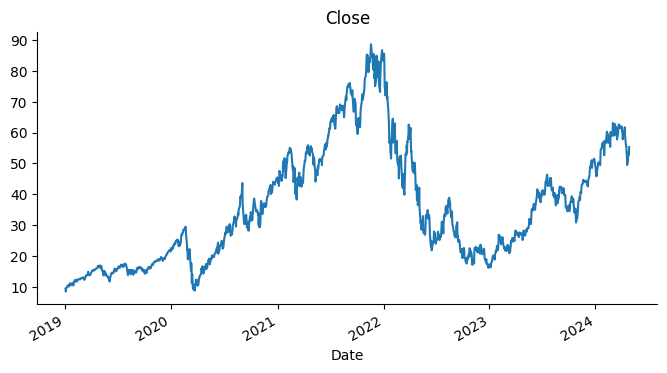

In [14]:
from matplotlib import pyplot as plt
df['Close'].plot(kind='line', figsize=(8, 4), title='Close')
plt.gca().spines[['top', 'right']].set_visible(False)

In [15]:
from datetime import datetime

In [16]:
# inplace=True makes the changes in the original dataframe
df.reset_index(inplace=True)
# normalize() method converts times to midnight
df['Date'] = df['Date'].dt.normalize()
df.set_index('Date', inplace=True)
df.sort_values('Date', ascending=True, inplace=True)

In [17]:
data = df
data.head()

,Open,High,Low,Close,Volume
Date,,,,,
2019-01-02,8.6950,9.5575,8.6825,9.3925,135832800.0
2019-01-03,8.9950,9.1025,8.4075,8.4825,165255200.0
2019-01-04,8.8875,9.6900,8.7925,9.5675,136482000.0
2019-01-07,9.6175,10.0375,9.5325,9.8725,106553200.0
2019-01-08,10.1725,10.2775,9.7250,10.1575,105811200.0


## Add Custom Indicators

In [18]:
data['return'] = np.log(data['Close'] / data['Close'].shift(1))

In [19]:
from finta import TA

In [20]:
#Create columns for technical indicators & add them to the dataframe
data['RSI'] = TA.RSI(data,16)
data['SMA'] = TA.SMA(data, 20)
data['SMA_L'] = TA.SMA(data, 41)
data['OBV'] = TA.OBV(data)
#data['VWAP'] = TA.VWAP(data)
data['EMA'] = TA.EMA(data)
data['ATR'] = TA.ATR(data)
data.fillna(0, inplace=True)

In [21]:
#Add momentum, volatitlity, & distance to the data_frame
data['momentum'] = data['return'].rolling(5).mean().shift(1)
data['volatility'] = data['return'].rolling(20).std().shift(1)
data['distance'] = (data['Close'] - data['Close'].rolling(50).mean()).shift(1)

In [22]:
#Perform a simple linear regression direction prediction
lags = 5

cols = []
for lag in range(1, lags + 1):
  col = f'lag_{lag}'
  data[col] = data['Close'].shift(lag)
  cols.append(col)

data.dropna(inplace=True)

reg = np.linalg.lstsq(data[cols], data['Close'], rcond=None)[0]
data['Prediction'] = np.dot(data[cols], reg)

In [23]:
data.tail()

,Open,High,Low,Close,Volume,return,RSI,SMA,SMA_L,OBV,...,ATR,momentum,volatility,distance,lag_1,lag_2,lag_3,lag_4,lag_5,Prediction
Date,,,,,,,,,,,,,,,,,,,,,
2024-04-22,50.380001,51.770000,49.169998,50.919998,71302400.0,0.028687,35.299127,58.2835,59.439025,7.524869e+09,...,2.950000,-3.424237e-02,0.028858,-9.876201,49.480000,52.750000,53.709999,55.779999,55.770000,49.616935
2024-04-23,51.619999,53.619999,51.490002,53.189999,75917500.0,0.043615,41.149447,57.8435,59.282195,7.600787e+09,...,2.994286,-1.819607e-02,0.030111,-8.283602,50.919998,49.480000,52.750000,53.709999,55.779999,50.940544
2024-04-24,54.320000,54.910000,52.830002,53.709999,72158400.0,0.009729,42.421590,57.4585,59.140000,7.672945e+09,...,2.795000,-9.508995e-03,0.032440,-5.872002,53.189999,50.919998,49.480000,52.750000,53.709999,53.190811
2024-04-25,50.900002,53.189999,50.480000,52.849998,86413600.0,-0.016142,40.863320,57.0035,58.967805,7.586531e+09,...,2.803572,3.122502e-17,0.032667,-5.235001,53.709999,53.189999,50.919998,49.480000,52.750000,53.669639
2024-04-26,54.029999,55.869999,53.770000,55.279999,67546000.0,0.044953,46.757830,56.6895,58.878537,7.654077e+09,...,2.922858,3.787822e-04,0.032521,-6.017202,52.849998,53.709999,53.189999,50.919998,49.480000,52.808386


# RL Environment Setup

In [24]:
#Create a function to properly format data frame to be passed through environment
def signals(env):
    start = env.frame_bound[0] - env.window_size
    end = env.frame_bound[1]
    prices = env.df.loc[:,'Close'].to_numpy()[start:end]
    #signal_features = env.df.loc[:, ['Open','High','Low','Volume','return','trade_count','momentum','volatility','distance','RSI','OBV','SMA','SMA_L','vwap','EMA','ATR', 'Prediction']].to_numpy()[start:end]
    signal_features = env.df.loc[:, ['Open','High','Low','Volume']].to_numpy()[start:end]
    return prices, signal_features

In [25]:
#Replace default data process with custom function from above
class MyCustomEnv(StocksEnv):  # the MyCustomEnv class is declared, and it is inheriting from a Gym class named StocksEnv. This means that MyCustomEnv will have all the attributes and methods of StocksEnv, and you can also add additional attributes and methods or override existing ones.
    _process_data = signals # this line declares a class-level variable _process_data and assigns it the value signals, which is defined above

In [26]:
#Initialize an environment setting the window size and train data
window_size = 65
start_index = window_size
end_train_index = round(len(data)*0.80)
end_val_index = len(data)

env2 = MyCustomEnv(df=data, window_size=window_size, frame_bound=(start_index, end_train_index))

In [27]:
#Create a Dummy Vector of our environment
env_maker = lambda: env2  # This lambda (anonymous) function takes no arguments and simply returns the value of env2.
env = DummyVecEnv([env_maker]) # is an evironment constructor from stable_baselines3. env is now initialized with the environment env2, wrapped inside a DummyVecEnv. The use of env_maker (which is a list) allows for dynamic instantiation of environments.

## Train Test

Here's a breakdown of what each line does in the next code cell:

**1) policy_kwargs = dict(optimizer_class=RMSpropTFLike, optimizer_kwargs=dict(eps=1e-5))**:

-This line creates a dictionary named **policy_kwargs**.

-Inside this dictionary, there's a key named **optimizer_class** which is set to **RMSpropTFLike**.

-Additionally, there's another key named **optimizer_kwargs**, which is set to another dictionary containing a single key-value pair **eps=1e-5**.  

**2)actor_critic = A2C('MlpPolicy', env, policy_kwargs=policy_kwargs, verbose=1):**

-This line initializes an Actor-Critic model using the A2C algorithm.

-**'MlpPolicy'** specifies the type of policy network to be used. In this case, it likely refers to a Multi-layer Perceptron (MLP) policy network.

-**env** refers to the environment in which the agent will learn. It's assumed that **env** has been previously defined and instantiated, representing the reinforcement learning environment.

-**policy_kwargs=policy_kwargs** passes the policy-specific keyword arguments defined earlier to the A2C algorithm.

-**verbose=1** specifies the verbosity level of the training process. Here,
**verbose=1** indicates that training progress will be printed.

**3) actor_critic.learn(total_timesteps=200000):**

-This line initiates the training of the A2C model.

-**total_timesteps=200000** specifies the total number of timesteps (or steps) the agent will take in the environment during training. This is a hyperparameter that determines the duration of training.


In summary, this code initializes an A2C agent with a specified policy network, optimizers, and environment, then proceeds to train the agent for a total of 200,000 timesteps.





In [28]:
#initialize our model and train
policy_kwargs = dict(optimizer_class=RMSpropTFLike, optimizer_kwargs=dict(eps=1e-5))
actor_critic = A2C('MlpPolicy', env, policy_kwargs=policy_kwargs, verbose=1)
actor_critic.learn(total_timesteps=200000)  # this determines the duration of the training

Streaming output truncated to the last 5000 lines.
|    value_loss         | 0.114    |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 383      |
|    iterations         | 4400     |
|    time_elapsed       | 57       |
|    total_timesteps    | 22000    |
| train/                |          |
|    entropy_loss       | -0.454   |
|    explained_variance | -0.022   |
|    learning_rate      | 0.0007   |
|    n_updates          | 4399     |
|    policy_loss        | -0.21    |
|    value_loss         | 2.19     |
------------------------------------
------------------------------------
| time/                 |          |
|    fps                | 384      |
|    iterations         | 4500     |
|    time_elapsed       | 58       |
|    total_timesteps    | 22500    |
| train/                |          |
|    entropy_loss       | -0.556   |
|    explained_variance | -0.0189  |
|    learning_rate      

# Testing the Model

In [29]:
#Create a new environment with the test data
env = MyCustomEnv(df=data, window_size=window_size, frame_bound=(end_train_index, end_val_index))
obs = env.reset() # The reset method will be called to initiate a new episode. You may assume that the step method will not be called before reset has been called. Moreover, reset should be called whenever a done signal has been issued. Users may pass the seed keyword to reset to initialize any random number generator that is used by the environment to a deterministic state.

In [36]:
while True: # main loop of RL agent interacting with an environment, taking actions based on predictions from an actor-critic model until the episode is done.
    obs = obs[np.newaxis, ...] # obs = obs[np.newaxis, ...]: This line seems to be reshaping or adding a new axis to the obs variable. The exact nature of this operation depends on what type obs is (likely a numpy array) and what [np.newaxis, ...] is doing
    action, _states = actor_critic.predict(obs) # uses A2C model (this is where you insert your policy) from stable_baselines3 to predict action, and the underscore in _states indicates that it's not going to be used in the subsequent code
    obs, rewards, done, info = env.step(action) # This line performs a step in the environment (env) by taking the action returned by the actor-critic model. It returns the new observation (obs), the rewards obtained from the action (rewards), whether the episode is done (done), and additional information (info).
    if done:
        print("info", info)
        break

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


TypeError: tuple indices must be integers or slices, not tuple

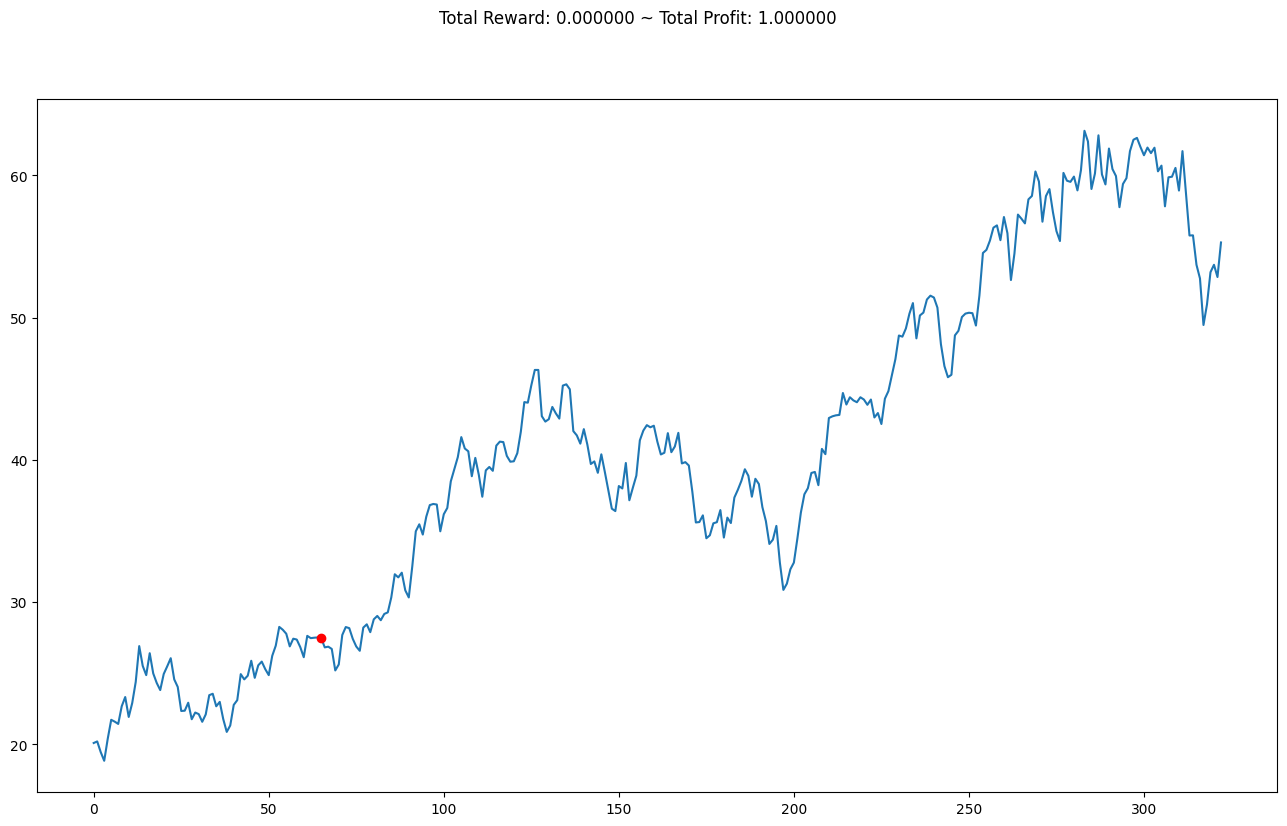

In [32]:
#Plot the results
plt.figure(figsize=(16,9))
env.render_all()
plt.show()

In [33]:
import quantstats as qs

In [34]:
qs.extend_pandas()

net_worth = pd.Series(env.history['total_profit'], index=data.index[end_train_index+1:end_val_index])
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)

KeyError: 'total_profit'

Things to do in the future

Create a callback function to stop and save best training weights

Train with longer/shorter time frames

Try different models like DQN or PPO

Bring in some quantstats to evaluate the performance better
